In [1]:
import pandas as pd
import spacy
from spacy import displacy
import re
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

import matplotlib.pyplot as plt

NER = spacy.load("en_core_web_sm")

# DEMO FOR NER BASED SKILLS EXTRACTION
<hr/>
This notebook demonstrates the hard-skills extraction process. The extraction of skills using the NER model from Spacy is the first step in our skills extraction process.
<hr/>
The first thing we do is load the dataset into Pandas dataframe and delete the columns we do not need.
**For the purposes of this demo we use a sample of the dataframe, containing only 130 rows**

In [3]:
def prepare_df(df, cols_to_keep=['title', 'company', 'description', 'position']):
    new_df=df[cols_to_keep]
    return new_df

In [4]:
df=prepare_df(pd.read_csv('jobs.csv'))

## HOW THE NER MODEL WORKS

<hr/>

NER model in spacy attempts to identify named entitites in the text. That is, it finds words which refer to a particular entity . For example `Python` is one of such words. Let's take a sample job posting and look at the model in action.

_Note: If `displacy.render(ready, style="ent")` does not work for you, try changing it to `displacy.serve(ready, style="ent")`_

In [6]:
example=df.iloc[3, 2]
ready = NER(example)
displacy.render(ready, style="ent")

**As can be seen, most technical skills are identified as ORG or Person. Let's apply this restriction, and test the NER model on another example**

_Note: If `displacy.render(ready, style="ent", options=choices)` does not work for you, try changing it to `displacy.serve(ready, style="ent", options=choices)`_

In [7]:
example=df.iloc[14, 2]
ready = NER(example)
choices = {"ents": ["ORG", "PERSON"]}
displacy.render(ready, style="ent", options=choices)

We can see that the model identifies some skills but also identifies a lot of entities which are not skills. Thus, we shall apply the model along with a couple of restrictions:
- Stop words. We have identified some words which indicate that the associated Entity is not a skill. So we do not include entitites containing these words.
- Uppercasing. Technical skills are the names of the programs (like Python, Java, etc) so we only keep entities which begin with the uppercase.
- We also make sure the company name is not identified as a skill by the model.
- We split the entities which contain one of `&`,`,`,`|`,`/` . For example an entity `management&cooperation` will be split into 2 skills: `management` and `cooperation`.

Such moves will reduce the amount of skills extracted and we may potentially miss a lot of skills. However, this is an acceptable limitation for the 1st step, because later we will use the extracted skills to retrieve more skills.

In [8]:
stops=['group', 'ontario', 'canada', 'rights', 'salary', 'company', 'operation', 'inc.', 'co-op', 'internship', 'startup', 'job', 'career', 'friday']

In [9]:
def hard_skills(descr, compName):
    name=compName.lower()
    info=NER(descr)
    raw_skills=[]
    for ent in info.ents:
        if ent.text[0].isupper():
            extracted=ent.text.lower()
            if (ent.label_=='ORG' or ent.label=='PERSON') and extracted not in name and name not in extracted and not any(stop in extracted for stop in stops):
                raw_skills.append(extracted)
    ready_skills=[]
    for skill in raw_skills:
        splitted=re.split('[&,|/]', skill)
        for true_skill in splitted:
            if true_skill not in ready_skills:
                ready_skills.append(true_skill)
    return ready_skills

In [10]:
def add_hard_skills(df):
    hs=[]
    for row in df.itertuples(index=False):
        hs.append(hard_skills(row.description, row.company))
    new_df=df
    new_df['hard_skills']=hs
    return new_df

In [11]:
df_hard=add_hard_skills(df)
df_hard.head(5)

,title,company,description,position,hard_skills
0,"Capital Markets QTS - Developer, Summer PEY 20...",RBC,What is the opportunity?\nAs a Developer withi...,developer,"[qts, capital markets, quantitative technology..."
1,Software Developer (Entry-Level),Traction,About Traction Design Group\n\nTraction Design...,developer,"[tdg, http, dom, ssl]"
2,"newJunior Image Processing Software Developer,...",Sunnybrook Health Sciences Centre,"Junior Image Processing Software Developer, Su...",developer,"[sunnybrook research institute, campbell cogni..."
3,"Software Developer Intern, Bachelors, Summer 2022",Google,Please complete your application before Decemb...,developer,"[bachelor, computer science, software developm..."
4,newJob Developer – Employment Ontario (Nov 202...,WoodGreen Community Services,Employment Type: Full-Time – CUPE Bargaining U...,developer,"[cupe bargaining, eo, agency policies, contrac..."


## Taking a look at extracted skills

- First of all, we collect all the extracted skills in a one, 1-dimensional array
- Then, we count the occurence of each skill in this array
- Then, we use the counting information to visualize the list of skills to a WordCloud

In [12]:
def flat_2d_arr(arr):
    flat=[]
    for small in arr:
        for element in small:
            flat.append(element)
    return flat

In [13]:
skills_arr=np.array(df['hard_skills'])
skills_arr=flat_2d_arr(skills_arr)

In [14]:
cnt = Counter() # Method for calculating occurences is taken from: https://stackoverflow.com/questions/4088265/sorted-word-frequency-count-using-python
for skill in skills_arr:
    cnt[skill] += 1
cnt.most_common()

[('javascript', 14),
 ('gta', 12),
 ('ssis', 10),
 ('sql', 10),
 ('bachelor', 9),
 ('ssrs', 9),
 ('hospital', 8),
 ('microsoft office', 8),
 ('microsoft', 7),
 ('business intelligence', 7),
 ('dental', 7),
 ('devops', 6),
 ('bi developer', 6),
 ('etl', 6),
 ('ssas', 6),
 ('microsoft bi', 6),
 ('php', 6),
 ('qts', 5),
 ('capital markets', 5),
 ('quantitative technology', 5),
 ('data structures', 5),
 ('react', 5),
 ('angular', 5),
 (' python', 5),
 ('new grad', 5),
 ('capital markets quantitative and technology services', 5),
 ('talent community', 5),
 ('tdg', 5),
 ('http', 5),
 ('dom', 5),
 ('ssl', 5),
 ('sunnybrook research institute', 5),
 ('campbell cognitive neurology research unit', 5),
 ('ondri', 5),
 ('canadian consortium on neurodegeneration in aging', 5),
 ('canadian alliance', 5),
 ('cahhm', 5),
 ('toronto dementia research alliance', 5),
 ('tdra', 5),
 ('brain-eye amyloid memory study', 5),
 ('beam', 5),
 ('medical imaging trials network', 5),
 ('mitnec', 5),
 ('pytorch', 5)

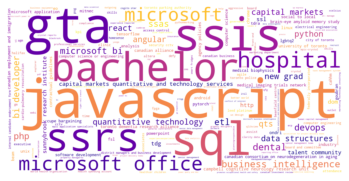

In [17]:
wordcloud = WordCloud(colormap='plasma', background_color='white', width=1600, height=800).generate_from_frequencies(cnt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**The word cloud shows the most frequent words in the array of skills. We've been editing 'stops' until we've became satisfied with the results.**
<hr/>
Thus, you can see the first portion of the skills we have extracted. Later we will analyze these skills to understand the linguistic patterns of skills as well as words which tend to appear close to the skills. We will use this information to extract more skills. 
<hr/>

# THE END OF THE DEMO